In [ ]:
# ============================================================================
# MAP 2: SOCIOECONOMIC EXPOSURE TRENDS 
# ============================================================================
# Creates new geodatabase to avoid broken data links
# ============================================================================

# Import necessary libraries
import arcpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import shutil

# Set up visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
%matplotlib inline

# Set upworkspace
print("="*70)
print("MAP 2: Socioeconomic Exposure Trends")
print("="*70)

arcpy.env.overwriteOutput = True
project = arcpy.mp.ArcGISProject("CURRENT")
project_path = project.filePath
project_folder = os.path.dirname(project_path)

# ============================================================================
# CREATE A NEW DEDICATED GEODATABASE
# ============================================================================

# Create a timestamp for unique geodatabase name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
new_gdb_name = f"Socioeconomic_Analysis_{timestamp}"
new_gdb_path = os.path.join(project_folder, f"{new_gdb_name}.gdb")

# Delete existing if present (clean start)
if arcpy.Exists(new_gdb_path):
    try:
        arcpy.Delete_management(new_gdb_path)
        print(f"Deleted existing: {new_gdb_path}")
    except:
        # If ArcGIS can't delete, try Python
        try:
            import shutil
            shutil.rmtree(new_gdb_path, ignore_errors=True)
        except:
            pass

# Create new geodatabase
print(f"\nCreating new geodatabase: {new_gdb_path}")
arcpy.CreateFileGDB_management(project_folder, f"{new_gdb_name}.gdb")
arcpy.env.workspace = new_gdb_path
print(f"✓ Workspace set to: {new_gdb_path}")

# ============================================================================
# STEP 1: DISCOVER LAYERS WITHOUT CREATING TEMPORARY FILES
# ============================================================================

print("\n" + "="*60)
print("STEP 1: Discovering Agriculture and Electricity Layers")
print("="*60)

active_map = project.listMaps()[0]

# Define available years
ag_years = [2001, 2005, 2010, 2015, 2020]
elec_years = [2000, 2005, 2010, 2015, 2020]
change_start_year = 2005
change_end_year = 2020

print(f"Change analysis period: {change_start_year} to {change_end_year}")

# Find layers and store their DATA SOURCES (not temporary copies)
ag_layers = {}
print("\nSearching for Agriculture layers...")
for layer in active_map.listLayers():
    layer_name = layer.name
    if "agriculture" in layer_name.lower():
        for year in ag_years:
            if str(year) in layer_name:
                # Get the ACTUAL data source path
                if hasattr(layer, 'dataSource') and layer.dataSource:
                    data_source = layer.dataSource
                else:
                    # If no dataSource, create a permanent copy
                    perm_fc_name = f"Agriculture_{year}_Perm"
                    perm_fc_path = os.path.join(new_gdb_path, perm_fc_name)
                    if not arcpy.Exists(perm_fc_path):
                        try:
                            arcpy.CopyFeatures_management(layer, perm_fc_path)
                            data_source = perm_fc_path
                            print(f"  Created permanent copy: {perm_fc_name}")
                        except:
                            data_source = None
                    else:
                        data_source = perm_fc_path
                
                if data_source:
                    ag_layers[year] = {
                        'name': layer_name,
                        'layer': layer,
                        'data_source': data_source
                    }
                    print(f"✓ Agriculture {year}: {layer_name}")
                break

# Find electricity layers
elec_layers = {}
print("\nSearching for Electricity layers...")
for layer in active_map.listLayers():
    layer_name = layer.name
    if "electricity" in layer_name.lower():
        for year in elec_years:
            if str(year) in layer_name:
                # Get the ACTUAL data source path
                if hasattr(layer, 'dataSource') and layer.dataSource:
                    data_source = layer.dataSource
                else:
                    # Create permanent copy
                    perm_fc_name = f"Electricity_{year}_Perm"
                    perm_fc_path = os.path.join(new_gdb_path, perm_fc_name)
                    if not arcpy.Exists(perm_fc_path):
                        try:
                            arcpy.CopyFeatures_management(layer, perm_fc_path)
                            data_source = perm_fc_path
                            print(f"  Created permanent copy: {perm_fc_name}")
                        except:
                            data_source = None
                    else:
                        data_source = perm_fc_path
                
                if data_source:
                    elec_layers[year] = {
                        'name': layer_name,
                        'layer': layer,
                        'data_source': data_source
                    }
                    print(f"✓ Electricity {year}: {layer_name}")
                break

# ============================================================================
# STEP 2: EXTRACT DATA DIRECTLY FROM SOURCES
# ============================================================================

print("\n" + "="*60)
print("STEP 2: Extracting Data Directly from Sources")
print("="*60)

def extract_data_directly(data_source, dataset_type, year):
    """Extract data directly without creating temporary feature classes"""
    try:
        # Extract values using SearchCursor directly on data source
        admin_values = {}
        placeholder_count = 0
        valid_count = 0
        
        # Try to find ADMIN field
        fields = [f.name for f in arcpy.ListFields(data_source)]
        admin_field = "ADMIN" if "ADMIN" in fields else "NAME" if "NAME" in fields else None
        
        if not admin_field:
            # Find first string field
            for field in fields:
                field_obj = [f for f in arcpy.ListFields(data_source) if f.name == field][0]
                if field_obj.type == 'String' and field not in ['Shape']:
                    admin_field = field
                    break
        
        if admin_field:
            with arcpy.da.SearchCursor(data_source, [admin_field, "value"]) as cursor:
                for admin, value in cursor:
                    if admin:
                        clean_admin = str(admin).strip()
                        if value is not None:
                            # Filter out placeholder values
                            if value <= -88800000:
                                placeholder_count += 1
                                admin_values[clean_admin] = None
                            else:
                                try:
                                    admin_values[clean_admin] = float(value)
                                    valid_count += 1
                                except:
                                    admin_values[clean_admin] = None
                        else:
                            admin_values[clean_admin] = None
            
            print(f"  {dataset_type} {year}: {valid_count} valid values, {placeholder_count} placeholders")
            return admin_values
        else:
            print(f"  ❌ Could not find admin field in {dataset_type} {year}")
            return None
            
    except Exception as e:
        print(f"  Error extracting {dataset_type} {year}: {e}")
        return None

# Extract agriculture data
ag_data_by_year = {}
print("\nExtracting Agriculture data...")
for year, layer_info in ag_layers.items():
    admin_values = extract_data_directly(layer_info['data_source'], "AG", year)
    if admin_values is not None:
        ag_data_by_year[year] = admin_values

# Extract electricity data
elec_data_by_year = {}
print("\nExtracting Electricity data...")
for year, layer_info in elec_layers.items():
    admin_values = extract_data_directly(layer_info['data_source'], "ELEC", year)
    if admin_values is not None:
        elec_data_by_year[year] = admin_values

In [3]:
# ============================================================================
# STEP 3: CALCULATE CHANGES WITH DATA-DRIVEN CLASSIFICATION
# ============================================================================

print("\n" + "="*60)
print("STEP 3: Calculating Changes with Smart Classification")
print("="*60)

# Get common countries with data for both start and end years
all_countries = set()

if change_start_year in ag_data_by_year and change_end_year in ag_data_by_year:
    start_ag_countries = set(ag_data_by_year[change_start_year].keys())
    end_ag_countries = set(ag_data_by_year[change_end_year].keys())
    ag_common = start_ag_countries.intersection(end_ag_countries)
    all_countries.update(ag_common)

if change_start_year in elec_data_by_year and change_end_year in elec_data_by_year:
    start_elec_countries = set(elec_data_by_year[change_start_year].keys())
    end_elec_countries = set(elec_data_by_year[change_end_year].keys())
    elec_common = start_elec_countries.intersection(end_elec_countries)
    if all_countries:
        all_countries = all_countries.intersection(elec_common)
    else:
        all_countries = elec_common

print(f"Countries with data for both Agriculture and Electricity: {len(all_countries)}")

# Calculate changes
master_data = []
for country in sorted(all_countries):
    country_data = {'Country': country}
    
    # Agriculture change
    if (change_start_year in ag_data_by_year and change_end_year in ag_data_by_year and
        country in ag_data_by_year[change_start_year] and country in ag_data_by_year[change_end_year]):
        
        ag_start = ag_data_by_year[change_start_year][country]
        ag_end = ag_data_by_year[change_end_year][country]
        
        if ag_start is not None and ag_end is not None:
            country_data['AG_Start'] = ag_start
            country_data['AG_End'] = ag_end
            country_data['AG_Change'] = ag_end - ag_start
    
    # Electricity change (and lack of electricity)
    if (change_start_year in elec_data_by_year and change_end_year in elec_data_by_year and
        country in elec_data_by_year[change_start_year] and country in elec_data_by_year[change_end_year]):
        
        elec_start = elec_data_by_year[change_start_year][country]
        elec_end = elec_data_by_year[change_end_year][country]
        
        if elec_start is not None and elec_end is not None:
            country_data['ELEC_Start'] = elec_start
            country_data['ELEC_End'] = elec_end
            country_data['ELEC_Change'] = elec_end - elec_start
            # Lack of electricity (100 - access %)
            country_data['ELEC_Lack_Start'] = 100 - elec_start
            country_data['ELEC_Lack_End'] = 100 - elec_end
            country_data['ELEC_Lack_Change'] = country_data['ELEC_Lack_End'] - country_data['ELEC_Lack_Start']
    
    # Only add if we have both
    if 'AG_Change' in country_data and 'ELEC_Change' in country_data:
        master_data.append(country_data)

df = pd.DataFrame(master_data)

if len(df) > 0:
    print(f"\n✅ Data preparation successful!")
    print(f"Countries with complete change data: {len(df)}")
    
    # ============================================================
    # DATA-DRIVEN CLASSIFICATION
    # ============================================================
    
    print("\n" + "-"*50)
    print("DATA-DRIVEN CLASSIFICATION BREAKS")
    print("-"*50)
    
    # Agriculture Change Classification - with FIXED monotonic bins
    ag_change = df['AG_Change'].dropna()
    
    if len(ag_change) > 0:
        # Get actual min and max
        ag_min = ag_change.min()
        ag_max = ag_change.max()
        
        print(f"Agriculture Change Range: {ag_min:.2f} to {ag_max:.2f} pp")
        
        # Create guaranteed monotonic breaks
        # Start with standard breaks
        standard_breaks = [-5.0, -2.0, -0.5, 0.5, 2.0, 5.0]
        
        # Filter to breaks within our data range and ensure monotonic
        ag_breaks = [ag_min]
        
        # Add standard breaks that are within range and greater than previous
        for brk in standard_breaks:
            if brk > ag_breaks[-1] and brk < ag_max:
                ag_breaks.append(brk)
        
        # Add max if not already included
        if ag_max > ag_breaks[-1]:
            ag_breaks.append(ag_max)
        else:
            # If max is already included or less, add a small increment
            ag_breaks.append(ag_breaks[-1] + 0.1)
        
        # Ensure all breaks are unique and strictly increasing
        ag_breaks = sorted(list(set(ag_breaks)))
        
        # Create class names
        ag_class_names = []
        for i in range(len(ag_breaks)-1):
            lower = ag_breaks[i]
            upper = ag_breaks[i+1]
            
            if upper <= -5:
                name = "Major Decrease"
            elif upper <= -2:
                name = "Significant Decrease"
            elif upper <= -0.5:
                name = "Slight Decrease"
            elif upper <= 0.5:
                name = "Stable"
            elif upper <= 2:
                name = "Slight Increase"
            elif upper <= 5:
                name = "Significant Increase"
            else:
                name = "Major Increase"
            
            ag_class_names.append(f"{name} ({lower:.1f} to {upper:.1f} pp)")
        
        print("Agriculture Change Classification:")
        for i in range(len(ag_breaks)-1):
            lower = ag_breaks[i]
            upper = ag_breaks[i+1]
            mask = (df['AG_Change'] >= lower) & (df['AG_Change'] < upper)
            if i == len(ag_breaks)-2:  # Last bin includes upper bound
                mask = (df['AG_Change'] >= lower) & (df['AG_Change'] <= upper)
            
            count = mask.sum()
            pct = (count / len(df)) * 100
            print(f"  {ag_class_names[i]}: {count} countries ({pct:.1f}%)")
        
        # Apply classification with error handling
        try:
            df['AG_Change_Class'] = pd.cut(df['AG_Change'], bins=ag_breaks, 
                                          labels=range(len(ag_breaks)-1), 
                                          include_lowest=False, right=True)
        except Exception as e:
            print(f"  ⚠ Error in pd.cut for Agriculture: {e}")
            print(f"  Using manual classification instead...")
            
            # Manual classification as fallback
            def classify_ag_change(value):
                if value < -5:
                    return 0
                elif value < -2:
                    return 1
                elif value < -0.5:
                    return 2
                elif value < 0.5:
                    return 3
                elif value < 2:
                    return 4
                elif value < 5:
                    return 5
                else:
                    return 6
            
            df['AG_Change_Class'] = df['AG_Change'].apply(classify_ag_change)
    
    # Electricity Lack Change Classification - with FIXED monotonic bins
    elec_lack_change = df['ELEC_Lack_Change'].dropna()
    
    if len(elec_lack_change) > 0:
        # Get actual min and max
        elec_min = elec_lack_change.min()
        elec_max = elec_lack_change.max()
        
        print(f"\nElectricity Lack Change Range: {elec_min:.2f} to {elec_max:.2f} pp")
        
        # Create guaranteed monotonic breaks
        standard_elec_breaks = [-2.0, -1.0, -0.5, 0, 0.5, 1.0, 2.0]
        
        elec_breaks = [elec_min]
        
        # Add standard breaks that are within range
        for brk in standard_elec_breaks:
            if brk > elec_breaks[-1] and brk < elec_max:
                elec_breaks.append(brk)
        
        # Add max if not already included
        if elec_max > elec_breaks[-1]:
            elec_breaks.append(elec_max)
        else:
            elec_breaks.append(elec_breaks[-1] + 0.01)
        
        # Ensure all breaks are unique and strictly increasing
        elec_breaks = sorted(list(set(elec_breaks)))
        
        # Create class names
        elec_class_names = []
        for i in range(len(elec_breaks)-1):
            lower = elec_breaks[i]
            upper = elec_breaks[i+1]
            
            if upper <= -2:
                name = "Major Improvement"
            elif upper <= -1:
                name = "Significant Improvement"
            elif upper <= -0.5:
                name = "Moderate Improvement"
            elif upper <= 0:
                name = "Slight Improvement"
            elif upper <= 0.5:
                name = "Slight Worsening"
            elif upper <= 1:
                name = "Moderate Worsening"
            elif upper <= 2:
                name = "Significant Worsening"
            else:
                name = "Major Worsening"
            
            elec_class_names.append(f"{name} ({lower:.1f} to {upper:.1f} pp)")
        
        print("\nElectricity Lack Change Classification:")
        for i in range(len(elec_breaks)-1):
            lower = elec_breaks[i]
            upper = elec_breaks[i+1]
            mask = (df['ELEC_Lack_Change'] >= lower) & (df['ELEC_Lack_Change'] < upper)
            if i == len(elec_breaks)-2:  # Last bin includes upper bound
                mask = (df['ELEC_Lack_Change'] >= lower) & (df['ELEC_Lack_Change'] <= upper)
            
            count = mask.sum()
            pct = (count / len(df)) * 100
            print(f"  {elec_class_names[i]}: {count} countries ({pct:.1f}%)")
        
        # Apply classification with error handling
        try:
            df['ELEC_Lack_Change_Class'] = pd.cut(df['ELEC_Lack_Change'], bins=elec_breaks,
                                                 labels=range(len(elec_breaks)-1),
                                                 include_lowest=False, right=True)
        except Exception as e:
            print(f"  ⚠ Error in pd.cut for Electricity: {e}")
            print(f"  Using manual classification instead...")
            
            # Manual classification as fallback
            def classify_elec_change(value):
                if value < -2:
                    return 0
                elif value < -1:
                    return 1
                elif value < -0.5:
                    return 2
                elif value < 0:
                    return 3
                elif value < 0.5:
                    return 4
                elif value < 1:
                    return 5
                elif value < 2:
                    return 6
                else:
                    return 7
            
            df['ELEC_Lack_Change_Class'] = df['ELEC_Lack_Change'].apply(classify_elec_change)
    
    # Calculate combined trend
    def get_trend(ag_class, elec_class):
        """Determine overall vulnerability trend"""
        # Handle NaN values
        if pd.isna(ag_class) or pd.isna(elec_class):
            return "Insufficient Data"
        
        # Convert to numeric for calculation
        try:
            ag_num = int(ag_class)
            elec_num = int(elec_class)
        except:
            # If conversion fails, default to stable
            ag_num = 3
            elec_num = 3
        
        # Normalize to 0-1 scale (higher = worse)
        max_ag_classes = df['AG_Change_Class'].max() if 'AG_Change_Class' in df else 6
        max_elec_classes = df['ELEC_Lack_Change_Class'].max() if 'ELEC_Lack_Change_Class' in df else 7
        
        ag_norm = ag_num / max_ag_classes if max_ag_classes > 0 else 0.5
        elec_norm = elec_num / max_elec_classes if max_elec_classes > 0 else 0.5
        
        # Weighted combination
        combined = (ag_norm * 0.6 + elec_norm * 0.4)
        
        if combined > 0.8:
            return "Critically Worsening"
        elif combined > 0.6:
            return "Strongly Worsening"
        elif combined > 0.4:
            return "Worsening"
        elif combined > 0.3:
            return "Slightly Worsening"
        elif combined > 0.2:
            return "Stable"
        elif combined > 0.1:
            return "Slightly Improving"
        elif combined > 0:
            return "Improving"
        else:
            return "Strongly Improving"
    
    # Apply trend classification
    df['Trend'] = df.apply(lambda row: get_trend(row.get('AG_Change_Class'), row.get('ELEC_Lack_Change_Class')), axis=1)
    
else:
    print("❌ No complete change data records found!")


STEP 3: Calculating Changes with Smart Classification
Countries with data for both Agriculture and Electricity: 47

✅ Data preparation successful!
Countries with complete change data: 27

--------------------------------------------------
DATA-DRIVEN CLASSIFICATION BREAKS
--------------------------------------------------
Agriculture Change Range: -17.78 to 3.49 pp
Agriculture Change Classification:
  Major Decrease (-17.8 to -5.0 pp): 1 countries (3.7%)
  Significant Decrease (-5.0 to -2.0 pp): 5 countries (18.5%)
  Slight Decrease (-2.0 to -0.5 pp): 5 countries (18.5%)
  Stable (-0.5 to 0.5 pp): 8 countries (29.6%)
  Slight Increase (0.5 to 2.0 pp): 5 countries (18.5%)
  Significant Increase (2.0 to 3.5 pp): 3 countries (11.1%)

Electricity Lack Change Range: -28.90 to 0.00 pp

Electricity Lack Change Classification:
  Major Improvement (-28.9 to -2.0 pp): 21 countries (77.8%)
  Significant Improvement (-2.0 to -1.0 pp): 1 countries (3.7%)
  Moderate Improvement (-1.0 to -0.5 pp): 1

In [ ]:
# ============================================================================
# STEP 4: CREATE PERMANENT MASTER FEATURE CLASS
# ============================================================================

print("\n" + "="*60)
print("STEP 4: Creating Permanent Master Feature Class")
print("="*60)

# Create master feature class from a permanent source
master_fc_name = f"Socioeconomic_Change_Master_{timestamp}"
master_fc = os.path.join(new_gdb_path, master_fc_name)

# Use the end year agriculture layer as base (create permanent copy)
base_ag_info = ag_layers.get(change_end_year)
if base_ag_info:
    # Copy to permanent location
    arcpy.CopyFeatures_management(base_ag_info['data_source'], master_fc)
    print(f"✓ Created master feature class: {master_fc}")
    
    # Add analysis fields
    analysis_fields = [
        ["AG_Start", "DOUBLE"],
        ["AG_End", "DOUBLE"],
        ["AG_Change", "DOUBLE"],
        ["ELEC_Start", "DOUBLE"],
        ["ELEC_End", "DOUBLE"],
        ["ELEC_Change", "DOUBLE"],
        ["ELEC_Lack_Start", "DOUBLE"],
        ["ELEC_Lack_End", "DOUBLE"],
        ["ELEC_Lack_Change", "DOUBLE"],
        ["AG_Change_Class", "SHORT"],
        ["ELEC_Lack_Change_Class", "SHORT"],
        ["Trend", "TEXT", 50]
    ]
    
    for field_name, field_type, *args in analysis_fields:
        if not arcpy.ListFields(master_fc, field_name):
            if len(args) > 0:
                arcpy.AddField_management(master_fc, field_name, field_type, field_length=args[0])
            else:
                arcpy.AddField_management(master_fc, field_name, field_type)
    
    print("✓ Added analysis fields")
    
    # Update with calculated data
    print("Populating change data...")
    
    # Create lookup dictionary
    data_lookup = {}
    for _, row in df.iterrows():
        data_lookup[row['Country']] = {
            'AG_Start': row.get('AG_Start'),
            'AG_End': row.get('AG_End'),
            'AG_Change': row.get('AG_Change'),
            'ELEC_Start': row.get('ELEC_Start'),
            'ELEC_End': row.get('ELEC_End'),
            'ELEC_Change': row.get('ELEC_Change'),
            'ELEC_Lack_Start': row.get('ELEC_Lack_Start'),
            'ELEC_Lack_End': row.get('ELEC_Lack_End'),
            'ELEC_Lack_Change': row.get('ELEC_Lack_Change'),
            'AG_Change_Class': int(row['AG_Change_Class']) if pd.notna(row['AG_Change_Class']) else None,
            'ELEC_Lack_Change_Class': int(row['ELEC_Lack_Change_Class']) if pd.notna(row['ELEC_Lack_Change_Class']) else None,
            'Trend': row.get('Trend')
        }
    
    # Update feature class
    update_fields = ["ADMIN"] + [f[0] for f in analysis_fields]
    
    records_updated = 0
    with arcpy.da.UpdateCursor(master_fc, update_fields) as cursor:
        for row in cursor:
            admin = str(row[0]).strip() if row[0] else None
            
            if admin and admin in data_lookup:
                data = data_lookup[admin]
                
                # Update all fields
                for i, (field_name, _, *_) in enumerate(analysis_fields, 1):
                    row[i] = data.get(field_name)
                
                records_updated += 1
            
            cursor.updateRow(row)
    
    print(f"✓ Updated {records_updated} records")
    
else:
    print("❌ Could not find base agriculture layer")
    raise Exception("Need agriculture layer for base feature class")

# ============================================================================
# STEP 5: GENERATE STATISTICS AND ADD TO MAP
# ============================================================================

print("\n" + "="*60)
print("STEP 5: Generating Statistics and Adding to Map")
print("="*60)

if len(df) > 0:
    print(f"\n✅ ANALYSIS COMPLETE!")
    print(f"Period: {change_start_year} to {change_end_year}")
    print(f"Countries analyzed: {len(df)}")
    
    print("\n" + "-"*50)
    print("KEY FINDINGS")
    print("-"*50)
    
    # Agriculture trends
    ag_increase = (df['AG_Change'] > 0).sum()
    ag_decrease = (df['AG_Change'] < 0).sum()
    ag_stable = (df['AG_Change'] == 0).sum()
    
    print(f"Agriculture Dependence Trends:")
    print(f"  Increasing: {ag_increase} countries ({ag_increase/len(df)*100:.1f}%)")
    print(f"  Decreasing: {ag_decrease} countries ({ag_decrease/len(df)*100:.1f}%)")
    print(f"  Stable: {ag_stable} countries ({ag_stable/len(df)*100:.1f}%)")
    print(f"  Average change: {df['AG_Change'].mean():.2f} pp")
    
    # Electricity trends (using lack of electricity)
    elec_worsening = (df['ELEC_Lack_Change'] > 0).sum()
    elec_improving = (df['ELEC_Lack_Change'] < 0).sum()
    elec_stable = (df['ELEC_Lack_Change'] == 0).sum()
    
    print(f"\nElectricity Access Trends (Lack of Electricity):")
    print(f"  Worsening (more people without electricity): {elec_worsening} countries ({elec_worsening/len(df)*100:.1f}%)")
    print(f"  Improving (fewer people without electricity): {elec_improving} countries ({elec_improving/len(df)*100:.1f}%)")
    print(f"  Stable: {elec_stable} countries ({elec_stable/len(df)*100:.1f}%)")
    print(f"  Average change in lack: {df['ELEC_Lack_Change'].mean():.2f} pp")
    
    # Combined trends
    print(f"\nCombined Vulnerability Trends:")
    trend_counts = df['Trend'].value_counts()
    for trend, count in trend_counts.items():
        pct = count / len(df) * 100
        print(f"  {trend}: {count} countries ({pct:.1f}%)")
    
    # Most concerning countries
    high_risk = df[(df['AG_Change'] > 2) & (df['ELEC_Lack_Change'] > 0.5)]
    if len(high_risk) > 0:
        print(f"\n⚠ HIGHEST RISK COUNTRIES (Increasing agriculture + Worsening electricity):")
        high_risk_sorted = high_risk.sort_values(['AG_Change', 'ELEC_Lack_Change'], ascending=[False, False])
        for i, (_, row) in enumerate(high_risk_sorted.head(5).iterrows(), 1):
            print(f"  {i}. {row['Country']}: Ag +{row['AG_Change']:.1f} pp, Elec Lack +{row['ELEC_Lack_Change']:.1f} pp")
    
    # Most improving countries
    improving = df[(df['AG_Change'] < -2) & (df['ELEC_Lack_Change'] < -0.5)]
    if len(improving) > 0:
        print(f"\n✅ MOST IMPROVING COUNTRIES (Decreasing agriculture + Improving electricity):")
        improving_sorted = improving.sort_values(['AG_Change', 'ELEC_Lack_Change'])
        for i, (_, row) in enumerate(improving_sorted.head(5).iterrows(), 1):
            print(f"  {i}. {row['Country']}: Ag {row['AG_Change']:+.1f} pp, Elec Lack {row['ELEC_Lack_Change']:+.1f} pp")

# Add to map
try:
    active_map.addDataFromPath(master_fc)
    
    # Rename for clarity
    for layer in active_map.listLayers():
        if master_fc in layer.dataSource:
            layer.name = f"Map 2: Socioeconomic Change {change_start_year}-{change_end_year}"
            print(f"\n✓ Added to map: '{layer.name}'")
            break
            
except Exception as e:
    print(f"⚠ Could not add layer: {e}")
    print(f"Manual: Add {master_fc} from Catalog pane")


STEP 6: Creating Improved Visualizations


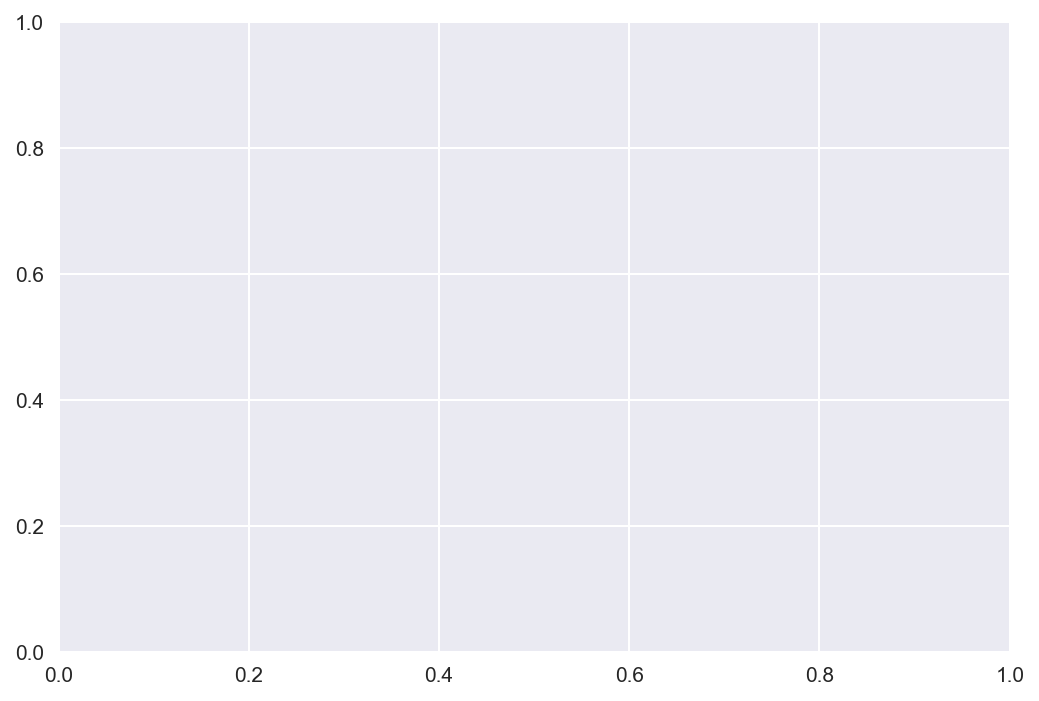

<class 'KeyError'>: 'Trend'

In [22]:
# ============================================================================
# STEP 6: CREATE IMPROVED VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("STEP 6: Creating Improved Visualizations")
print("="*60)

if len(df) > 0:
    # Create optimized figure with 3 subplots
    fig = plt.figure(figsize=(18, 12))
    
    # ========== SUBPLOT 1: IMPROVED BIVARIATE CHANGE ANALYSIS ==========
    ax1 = plt.subplot(2, 2, 1)
    
    # Enhanced color scheme for trends
    trend_colors = {
        "Strongly Improving": "#1A9850",    # Dark Green
        "Improving": "#91CF60",             # Green
        "Slightly Improving": "#D9EF8B",    # Light Green
        "Stable": "#FFFFBF",                # Yellow
        "Slightly Worsening": "#FEE08B",    # Light Orange
        "Worsening": "#FC8D59",             # Orange
        "Strongly Worsening": "#D73027",    # Red
        "Critically Worsening": "#800026"   # Dark Red
    }
    
    # Apply colors
    colors = [trend_colors.get(trend, "#999999") for trend in df['Trend']]
    
    # Calculate point sizes based on combined change magnitude
    change_magnitude = np.sqrt(df['AG_Change']**2 + df['ELEC_Lack_Change']**2)
    sizes = 50 + (change_magnitude / change_magnitude.max()) * 150
    
    # Create scatter plot
    scatter = ax1.scatter(df['AG_Change'], df['ELEC_Lack_Change'], 
                         c=colors, s=sizes, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add quadrant lines
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.7, linewidth=1)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.7, linewidth=1)
    
    # Add classification boundaries (using our data-driven breaks)
    # Agriculture boundaries
    for x in [-5, -2, -0.5, 0.5, 2, 5]:
        ax1.axvline(x=x, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
    
    # Electricity lack boundaries
    for y in [-2, -1, -0.5, 0, 0.5, 1, 2]:
        ax1.axhline(y=y, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
    
    # Label quadrants with improved positioning
    quadrant_texts = [
        (df['AG_Change'].max()*0.7, df['ELEC_Lack_Change'].max()*0.8, 
         'Economic Risk ↑\nAdaptive Capacity ↓\n(High Concern)', '#D73027'),
        (df['AG_Change'].min()*0.7, df['ELEC_Lack_Change'].min()*0.8,
         'Economic Risk ↓\nAdaptive Capacity ↑\n(Positive Trend)', '#1A9850'),
        (df['AG_Change'].max()*0.7, df['ELEC_Lack_Change'].min()*0.8,
         'Economic Risk ↑\nAdaptive Capacity ↑\n(Mixed)', '#FC8D59'),
        (df['AG_Change'].min()*0.7, df['ELEC_Lack_Change'].max()*0.8,
         'Economic Risk ↓\nAdaptive Capacity ↓\n(Mixed)', '#FEE08B')
    ]
    
    for x, y, text, color in quadrant_texts:
        ax1.text(x, y, text, fontsize=9, alpha=0.8, ha='center', 
                color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    ax1.set_xlabel(f'Change in Agriculture (% of GDP, {change_start_year}-{change_end_year})', 
                   fontsize=11, fontweight='bold')
    ax1.set_ylabel(f'Change in Lack of Electricity Access (% population, {change_start_year}-{change_end_year})', 
                   fontsize=11, fontweight='bold')
    ax1.set_title('Bivariate Change Analysis: Economic Exposure vs Adaptive Capacity', 
                  fontsize=13, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3)
    
    # Add classification guide
    ax1.text(0.02, 0.98, 'Agriculture Change:\n← Decrease    Increase →\n\nElectricity Lack:\n↓ Improvement    Worsening ↑', 
             transform=ax1.transAxes, fontsize=8, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Label key countries (most extreme in each quadrant)
    key_countries = pd.concat([
        df.nlargest(2, 'AG_Change'),      # Top agriculture increases
        df.nsmallest(2, 'AG_Change'),     # Top agriculture decreases
        df.nlargest(2, 'ELEC_Lack_Change'), # Top electricity lack increases
        df.nsmallest(2, 'ELEC_Lack_Change')  # Top electricity lack decreases
    ]).drop_duplicates()
    
    for _, row in key_countries.iterrows():
        ax1.annotate(row['Country'], (row['AG_Change'], row['ELEC_Lack_Change']),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=9, alpha=0.9, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='black', alpha=0.5))
    
    # ========== SUBPLOT 2: TREND DISTRIBUTION ==========
    ax2 = plt.subplot(2, 2, 2)
    
    # Sort trends logically
    trend_order = [
        'Strongly Improving', 'Improving', 'Slightly Improving',
        'Stable', 'Slightly Worsening', 'Worsening', 
        'Strongly Worsening', 'Critically Worsening'
    ]
    
    # Filter to existing trends
    existing_trends = [t for t in trend_order if t in df['Trend'].unique()]
    trend_counts = df['Trend'].value_counts().reindex(existing_trends)
    
    # Create horizontal bar chart
    bars = ax2.barh(range(len(trend_counts)), trend_counts.values, 
                   color=[trend_colors[t] for t in trend_counts.index], 
                   edgecolor='black', height=0.7)
    
    ax2.set_yticks(range(len(trend_counts)))
    ax2.set_yticklabels(trend_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Countries', fontsize=11)
    ax2.set_title('Distribution of Vulnerability Trends', fontsize=13, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add count labels
    for i, (bar, count) in enumerate(zip(bars, trend_counts.values)):
        ax2.text(count + 0.5, i, str(count), va='center', fontweight='bold', fontsize=10)
        # Add percentage
        pct = (count / len(df)) * 100
        ax2.text(count + 0.5, i - 0.2, f'({pct:.1f}%)', va='center', fontsize=8)
    
    # ========== SUBPLOT 3: TOP CHANGE COUNTRIES COMPARISON ==========
    ax3 = plt.subplot(2, 2, (3, 4))  # Span two columns
    
    # Select countries with most significant combined changes
    df['Combined_Change_Magnitude'] = np.sqrt(df['AG_Change']**2 + df['ELEC_Lack_Change']**2)
    top_changes = df.nlargest(12, 'Combined_Change_Magnitude')
    
    # Sort by agriculture change for better visualization
    top_changes = top_changes.sort_values('AG_Change', ascending=False)
    
    # Create grouped bar chart
    x = np.arange(len(top_changes))
    width = 0.35
    
    # Agriculture bars
    bars1 = ax3.bar(x - width/2, top_changes['AG_Change'], width,
                    color='#8C564B', alpha=0.8, 
                    label=f'Agriculture Change (pp)', edgecolor='black')
    
    # Electricity lack bars (note: positive = bad)
    bars2 = ax3.bar(x + width/2, top_changes['ELEC_Lack_Change'], width,
                    color='#1F77B4', alpha=0.8,
                    label=f'Lack of Electricity Change (pp)', edgecolor='black')
    
    # Color x-tick labels by trend
    ax3.set_xticks(x)
    ax3.set_xticklabels(top_changes['Country'], rotation=45, ha='right', fontsize=10)
    
    # Color labels by trend
    for i, (tick, trend) in enumerate(zip(ax3.get_xticklabels(), top_changes['Trend'])):
        tick.set_color(trend_colors.get(trend, "#000000"))
        tick.set_fontweight('bold')
    
    ax3.set_ylabel('Change (percentage points)', fontsize=11, fontweight='bold')
    ax3.set_title(f'Countries with Most Significant Changes ({change_start_year}-{change_end_year})',
                  fontsize=14, fontweight='bold', pad=20)
    ax3.axhline(y=0, color='black', linewidth=1.5)
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars, offset in [(bars1, -width/2), (bars2, width/2)]:
        for bar in bars:
            height = bar.get_height()
            if abs(height) > 0.01:  # Label non-zero values
                va = 'bottom' if height >= 0 else 'top'
                y_offset = 0.3 if height >= 0 else -0.8
                ax3.text(bar.get_x() + bar.get_width()/2,
                        height + y_offset,
                        f'{height:.1f}', ha='center', va=va,
                        fontsize=9, fontweight='bold')
    
    # Add trend indicators
    for i, trend in enumerate(top_changes['Trend']):
        color = trend_colors.get(trend, "#999999")
        ax3.text(i, ax3.get_ylim()[1] * 0.95, trend.split()[0], 
                ha='center', fontsize=8, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    ax3.legend(loc='upper right', fontsize=10)
    
    plt.tight_layout()
    
    # Save the figure
    fig_path = os.path.join(project_folder, f"socioeconomic_change_analysis_{timestamp}.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✓ Saved analysis figure to: {fig_path}")
    
else:
    print("⚠ No data for visualization creation")

# Export dataframe to CSV
csv_path = os.path.join(project_folder, f"socioeconomic_change_analysis_{timestamp}.csv")
if len(df) > 0:
    df.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"\n✓ Exported analysis data to: {csv_path}")


DISPLAYING YOUR MAP

BIVARIATE LEGEND

COLOR INTERPRETATION GUIDE

DATA SOURCE


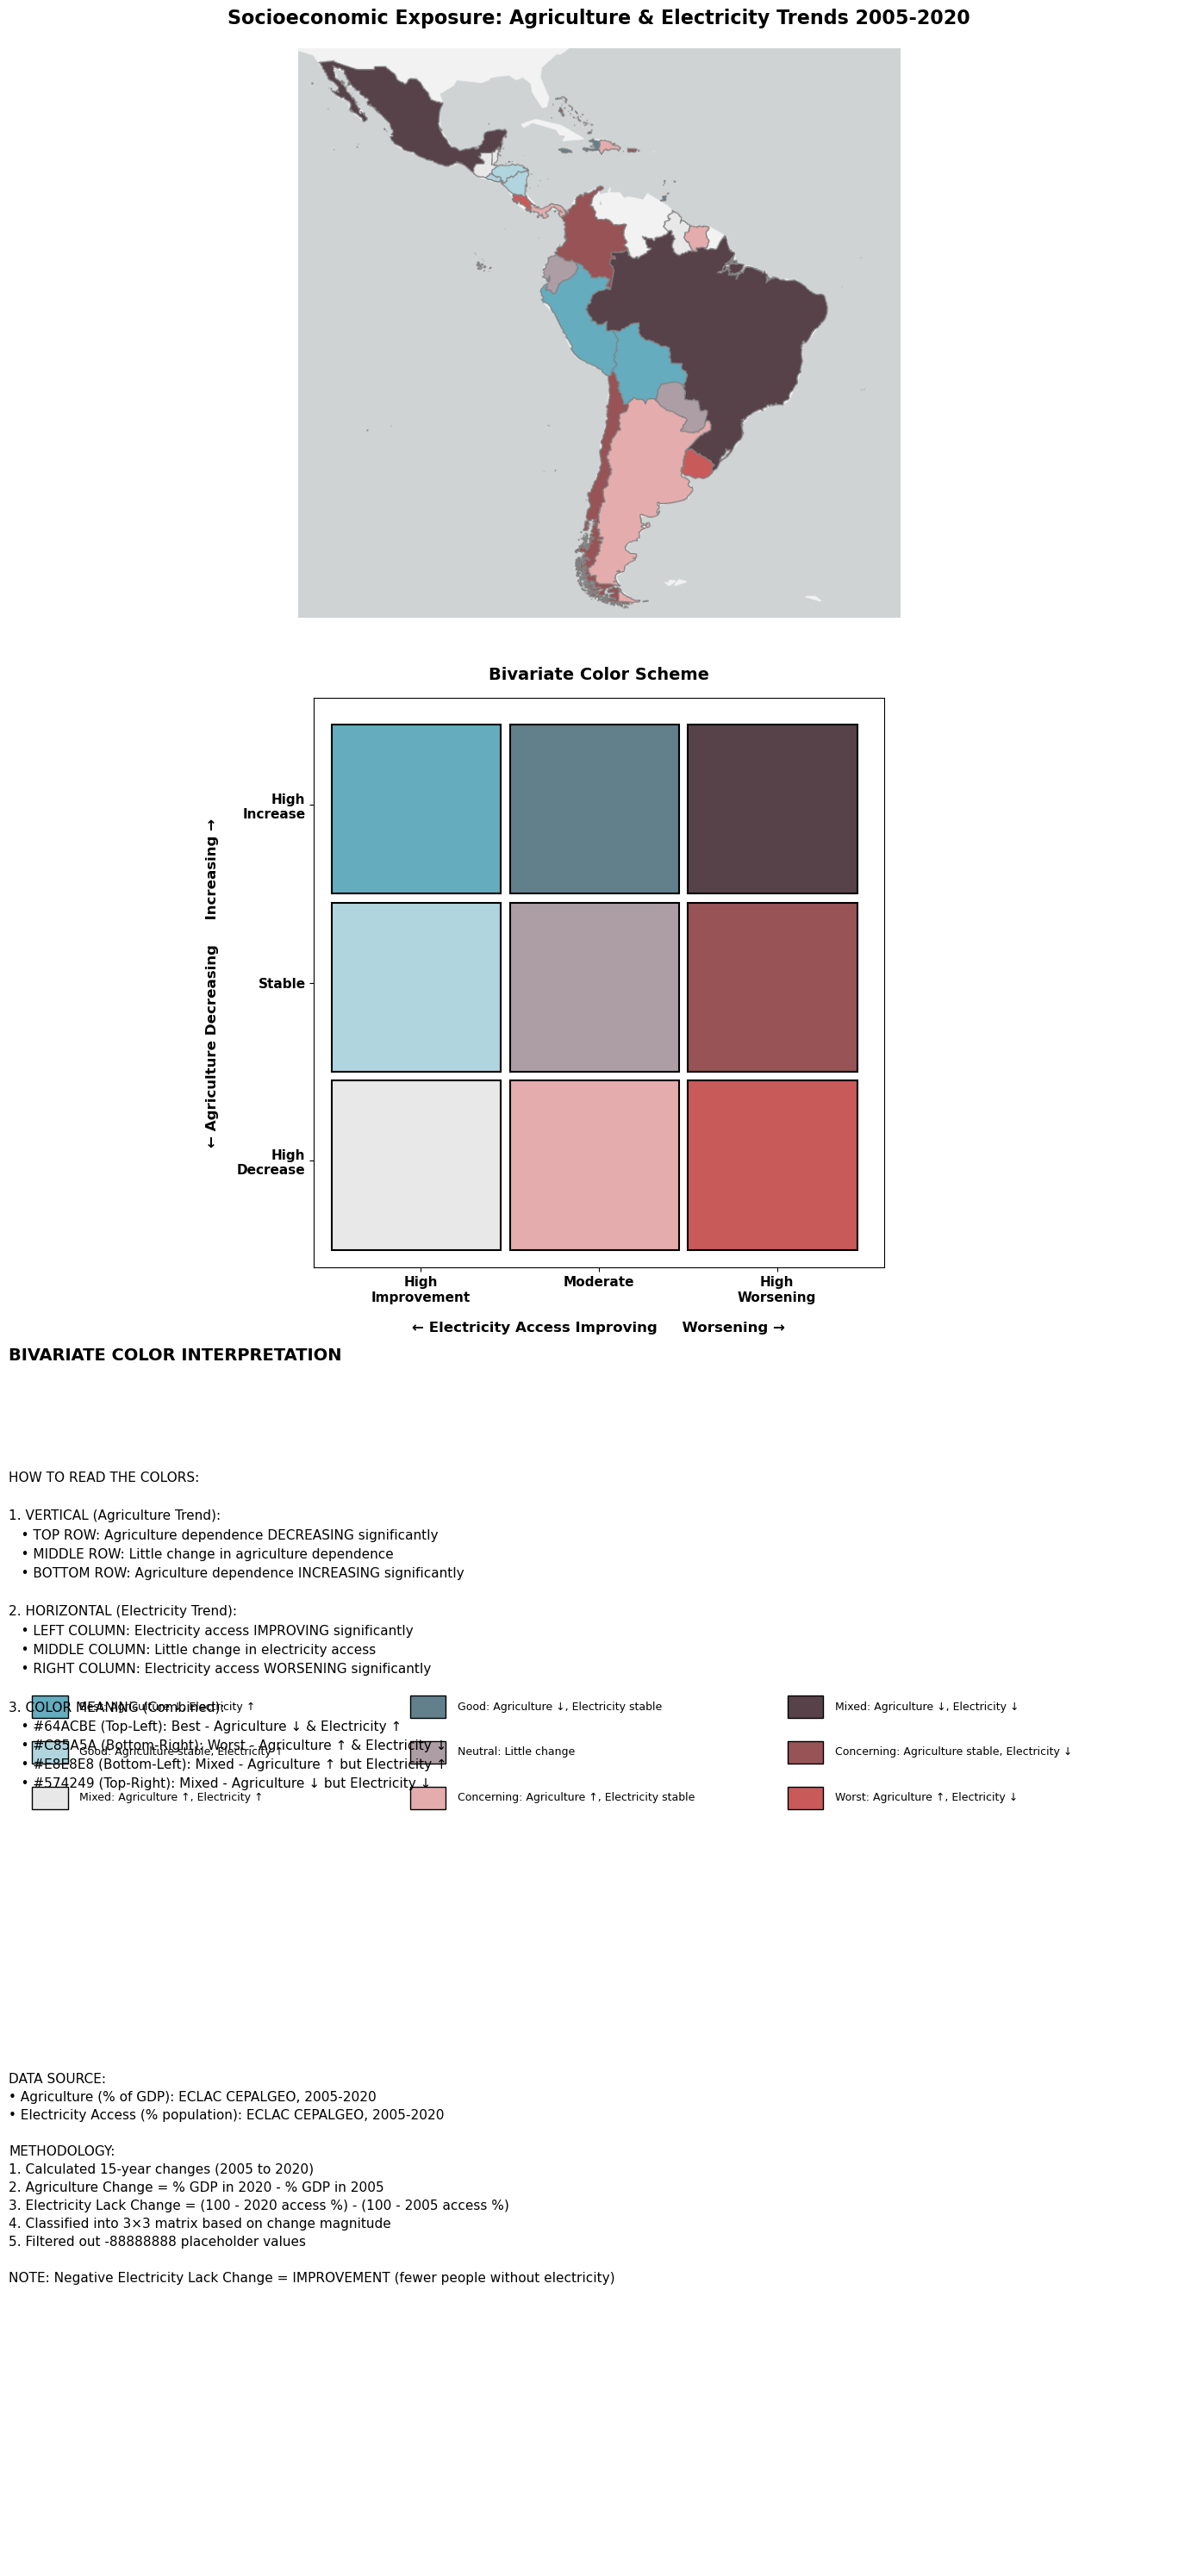


YOUR BIVARIATE COLOR SCHEME INTERPRETATION

YOUR EXACT COLORS (3×3 Grid):

TOP ROW (Agriculture Decreasing):
• #64ACBE (Top-Left): Agriculture ↓ + Electricity ↑ = BEST
• #627F8C (Top-Middle): Agriculture ↓ + Electricity → = GOOD  
• #574249 (Top-Right): Agriculture ↓ + Electricity ↓ = MIXED

MIDDLE ROW (Agriculture Stable):
• #B0D5DF (Middle-Left): Agriculture → + Electricity ↑ = GOOD
• #AD9EA5 (Middle-Middle): Agriculture → + Electricity → = NEUTRAL
• #985356 (Middle-Right): Agriculture → + Electricity ↓ = CONCERNING

BOTTOM ROW (Agriculture Increasing):
• #E8E8E8 (Bottom-Left): Agriculture ↑ + Electricity ↑ = MIXED
• #E4ACAC (Bottom-Middle): Agriculture ↑ + Electricity → = CONCERNING
• #C85A5A (Bottom-Right): Agriculture ↑ + Electricity ↓ = WORST

POLICY IMPLICATIONS:
1. PRIORITY INTERVENTION (Red/Brown colors): #C85A5A, #985356, #E4ACAC
   - Countries becoming more vulnerable on BOTH fronts
   
2. POSITIVE MODELS (Blue/Teal colors): #64ACBE, #B0D5DF, #627F8C  
   - Countries improv